# Bayesian Gaussian process latent variable model (Bayesian GPLVM)
This notebook shows how to use the Bayesian GPLVM model. This is an unsupervised learning method usually used for dimensionality reduction. For an in-depth overview of GPLVMs,see **[1, 2]**.

In [1]:
import gpflow
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

%matplotlib inline

## Data
We are using the "three phase oil flow" dataset used initially for demonstrating the Generative Topographic mapping from **[3]**.

In [2]:
data = np.load('./data/three_phase_oil_flow.npz')

Following the GPflow notation we assume this dataset has a shape of `[num_data, output_dim]`

In [3]:
Y = tf.convert_to_tensor(data['Y'], dtype=default_float())

Integer in $[0, 2]$ indicating to which class the data point belongs (shape `[num_data,]`). Not used for model fitting, only for plotting afterwards.

In [4]:
labels = tf.convert_to_tensor(data['labels'])

In [5]:
print('Number of points: {} and Number of dimensions: {}'.format(Y.shape[0], Y.shape[1]))

Number of points: 100 and Number of dimensions: 12


## Model construction

We start by initializing the required variables:

In [6]:
latent_dim = 2  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0]  # number of data points

Initialize via PCA:

In [7]:
x_mean_init = tf.convert_to_tensor(ops.pca_reduce(Y, latent_dim), dtype=default_float())
x_var_init = tf.convert_to_tensor(np.ones((num_data, latent_dim)), dtype=default_float())

Pick inducing inputs randomly from dataset initialization:

In [8]:
inducing_variable = tf.convert_to_tensor(np.random.permutation(x_mean_init.numpy())[:num_inducing], dtype=default_float())

We construct a Squared Exponential (SE) kernel operating on the two-dimensional latent space. 
The `ARD` parameter stands for Automatic Relevance Determination, which in practice means that
we learn a different lengthscale for each of the input dimensions. See [Manipulating kernels](../advanced/kernels.ipynb) for more information.

In [9]:
lengthscale = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscale=lengthscale)

We have all the necessary ingredients to construct the model. GPflow contains an implementation of the Bayesian GPLVM:

In [10]:
gplvm = gpflow.models.BayesianGPLVM(Y,
            x_data_mean=x_mean_init,
            x_data_var=x_var_init,
            kernel=kernel,
            inducing_variable=inducing_variable)
# Instead of passing an inducing_variable directly, we can also set the num_inducing_variables argument to an integer, which will randomly pick from the data.

We change the default likelihood variance, which is 1, to 0.01.

In [11]:
gplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158267>

Next we optimize the created model. Given that this model has a deterministic evidence lower bound (ELBO), we can use SciPy's L-BFGS-B optimizer.

In [12]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)

@tf.function()
def optimization_step():
    return - gplvm.log_marginal_likelihood()

_ = opt.minimize(optimization_step, method="bfgs", variables=gplvm.trainable_variables, options=dict(maxiter=maxiter))

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


## Model analysis
GPflow allows you to inspect the learned model hyperparameters.

In [13]:
print_summary(gplvm)

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,1.0014211682118411e-13
BayesianGPLVM.kernel.lengthscale,Parameter,Softplus,,True,"(2,)",float64,[1.14739987e-06 2.07282634e+00]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.5667640316251449
BayesianGPLVM.x_data_mean,Parameter,,,True,"(100, 2)",float64,"[[-1.29939673e-09, 3.31490704e-09..."
BayesianGPLVM.x_data_var,Parameter,Softplus,,True,"(100, 2)",float64,"[[0.99999998, 1.0000004..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 2)",float64,"[[6.00076902, 1.08064707..."


## Plotting vs. Principle Component Analysis (PCA)
The reduction of the dimensionality of the dataset to two dimensions allows us to visualize the learned manifold.
We compare the Bayesian GPLVM's latent space to the deterministic PCA's one.

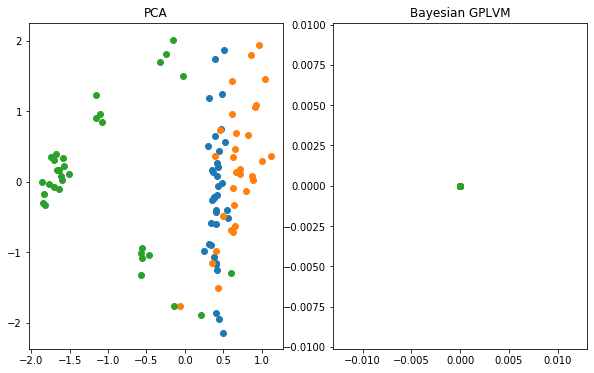

In [14]:
xpca = ops.pca_reduce(Y, latent_dim)
gplvm_x_mean = gplvm.x_data_mean.numpy()

f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(xpca[labels==i, 0], xpca[labels==i, 1], label=i)
    ax[1].scatter(gplvm_x_mean[labels==i, 0], gplvm_x_mean[labels==i, 1], label=i)
    ax[0].set_title('PCA')
    ax[1].set_title('Bayesian GPLVM')

## References
\[1\] Lawrence, Neil D. 'Gaussian process latent variable models for visualization of high dimensional data'. *Advances in Neural Information Processing Systems*. 2004.

\[2\] Titsias, Michalis, and Neil D. Lawrence. 'Bayesian Gaussian process latent variable model'. *Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics*. 2010.

\[3\] Bishop, Christopher M., and Gwilym D. James. 'Analysis of multiphase flows using dual-energy gamma densitometry and neural networks'. *Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment* 327.2-3 (1993): 580-593.